## PINNs Advection-Diffusion Equation

This notebook solves the advection-diffusion equation using a physics-informed neural network (PINN). The equation is given by:

\begin{cases}
\partial_t u + a \partial_x u = 0 \\
u(t=0, x) = u_0(x, \mu)
\end{cases}

where $u$ is the dependent variable, $t$ is time, $x$ is space, and $a$ is the diffusion coefficient (velocity) The initial condition is given by:

\begin{equation}
u(x,0) = \exp(-(x-0.5)^2/0.1^2)
\end{equation}



In [26]:
import os


import torch
import torch.nn as nn #is a PyTorch module that enables parallel processing of a neural network model across multiple GPUs
from torch.autograd import Variable

try:
    import torchinfo
    no_torchinfo = False
except ModuleNotFoundError:
    no_torchinfo = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")
import matplotlib.pyplot as plt
import numpy as np

torch loaded; device is cpu


In [27]:
class Net(nn.Module): 
    
    """Defines the neural network model"""
    def __init__(self):
        
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 30).double() 
        self.hidden_layer2 = nn.Linear(30, 30).double()
        self.hidden_layer3 = nn.Linear(30, 30).double()
        self.hidden_layer4 = nn.Linear(30, 10).double()
        self.output_layer = nn.Linear(10, 1).double()

    """Defines the sequence of operations that are applied to the input tensors to produce the output of the neural network"""
    def forward(self, x, t): 
    
        inputs = torch.cat([x,t], axis=1)
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)
        return output


def network_BC(t): #t to define u_theta
    return t

def network_BC_space(x): #t to define u_theta
    return x*(1-x)

In [28]:
class Network:

    def __init__(self,u0,tf,**kwargs):

        self.x_min, self.x_max = kwargs.get("x_min", 0.), kwargs.get("x_max", 1.)
        self.t_min, self.t_max = kwargs.get("t_min", 0.), kwargs.get("t_max", tf)

        self.a = kwargs.get("a", 1) #diffusion coefficient 
        self.learning_rate = kwargs.get("learning_rate", 1e-5)
        self.u0= u0 # fonction condition initiale
        self.tf = tf
        
        self.file_name = kwargs.get("file_name", "./best_network_transport2.pth")
        script_dir = os.getcwd()
        self.file_name = os.path.join(script_dir, self.file_name)

        self.create_network() #returns the current working directory
        self.load(self.file_name)
       #self.to_be_trained = kwargs.get("to_be_trained", self.to_be_trained)

    def __call__(self, *args):
        return self.net(*args)

    def create_network(self):
        """Creates the neural network model"""
        self.net = nn.DataParallel(Net()).to(device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate) #optimization algorithm
   
    def load(self, file_name):
        self.loss_history = []

        try:

            try:
                checkpoint = checkpoint = torch.load(file_name, map_location=torch.device('cpu'))
                
            except RuntimeError:
                checkpoint = torch.load(file_name, map_location=torch.device('cpu'))

            self.net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.loss = checkpoint['loss']

            try:
                self.loss_history = checkpoint['loss_history']
            except KeyError:
                pass

            self.to_be_trained = False
            print("network loaded successfully")
    
        except FileNotFoundError:

            self.to_be_trained = True
            print("network was not loaded from file: training needed")
    
    @staticmethod
    def save(file_name, epoch, net_state, optimizer_state, loss, loss_history):
        torch.save({
            epoch: epoch,
            'model_state_dict': net_state,
            'optimizer_state_dict': optimizer_state,
            'loss': loss,
            'loss_history': loss_history,
        }, file_name)

    def pde(self, x, t):
      
        u = self.u0(x) + network_BC(t) * self(x, t) * network_BC_space(x) # to count the perodicity of the solution PRIBLEME 
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0] 
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0] 

        return u_t + self.a * u_x

    
    """This method predicts the value of u based on the given input variables x, t and u0"""

    def predict_u_from_torch(self, x, t): # x tensor pour lequel on calcule la solution, t float, u0 float qu'on converti en tensor
        ones = torch.ones(x.shape, dtype=torch.double, device=device)
        pt_t = t * ones
        pred = self.u0(x) + network_BC(pt_t) * self(x, pt_t) * network_BC_space(x)
        #print("u0", pt_u0)
        #print("network_BC(pt_t)",network_BC(pt_t))
        #print("self",self(x, pt_t))
        #print("network_BC_space(x)",network_BC_space(x))
        #print("pred",pred)
        return pred

    #Pour l'instant c'est pas utilisé
    """This method predicts the value of u for a given input x and a mesh object"""
    def predict_u(self, x, t, mesh): # x float t float mesh object

        #We need to reshape the input x to be a column vector
        reshaped_x = x.reshape((x.size, 1))
        pt_x = Variable(torch.from_numpy(reshaped_x).double(), requires_grad=True).to(device)
        reshaped_t = t.reshape((x.size, 1))
        pt_t = Variable(torch.from_numpy(reshaped_t).double(), requires_grad=False).to(device)

        u_pred = self.u0(pt_x) + network_BC(pt_t) * self(pt_x, pt_t) * network_BC_space(pt_x)

        return u_pred.detach().cpu().numpy().reshape(x.shape)
    
    @staticmethod
    def random(min_value, max_value, shape, requires_grad=False, device=device):
        random_numbers = torch.rand(shape, device=device, dtype=torch.double, requires_grad=requires_grad)
        return min_value + (max_value - min_value) * random_numbers
    
    """This method generates the data for the training process"""
    def make_data(self, n_data):
        
        shape = (n_data, 1)

        """We generate for each variable a random number between the min and max value"""
        self.x_data = Network.random(self.x_min, self.x_max, shape)
        self.t_data = Network.random(self.t_min, self.t_max, shape)

        self.u_data = Network.u_exact(self.x_data, self.t_data, self.a , self.u0) 

    """This method generates the collocation points for the training process to enforce 
       the partial differential equation (PDE) constraints during training."""
    
    def make_collocation(self, n_collocation):

        shape = (n_collocation, 1)
        #These variables will be used to evaluate the PDE at the collocation points.
        #collocation points are additional points where the PDE will be evaluated to ensure that the neural network solution satisfies the PDE
        self.x_collocation = Network.random(self.x_min, self.x_max, shape, requires_grad=True)
        self.t_collocation = Network.random(self.t_min, self.t_max, shape, requires_grad=True)

        self.zeros = torch.zeros(shape, dtype=torch.double, device=device) #This will be used as a target for the PDE constraints.


    """This method trains the neural network using a combination of PDE constraints and data fitting."""
    def train(self, **kwargs):

        epochs = kwargs.get("epochs", 1000)
        n_collocation = kwargs.get("n_collocation", 50000)
        n_data = kwargs.get("n_data", 0) 

        plot_history = kwargs.get("plot_history", False)

        mse_cost_function = torch.nn.MSELoss()

        try:
            best_loss_value = self.loss.item()
        except AttributeError:
            best_loss_value = 1e10

        for epoch in range(epochs):
            self.optimizer.zero_grad()


            self.loss = 0

            if n_collocation > 0:
                # Loss based on PDE

                self.make_collocation(n_collocation)

                f_out = self.pde(self.x_collocation, self.t_collocation)
                mse_f = mse_cost_function(f_out, self.zeros) 

                self.loss += mse_f

            if n_data > 0:
                # Loss based on data
                self.make_data(n_data)

                u_pred = self.u0(self.x_data) + network_BC(self.t_data)  * self(self.x_data, self.t_data) * network_BC_space(self.x_data)

                mse_data = mse_cost_function(u_pred, self.u_data)

                self.loss += mse_data

            self.loss.backward()
            self.optimizer.step()
          

            self.loss_history.append(self.loss.item())

            if epoch % 500 == 0:
                print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")
                try:
                    self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
                except NameError:
                    pass

            if self.loss.item() < best_loss_value:
                print(f"epoch {epoch: 5d}: best loss = {self.loss.item():5.2e}")
                best_loss = self.loss.clone()
                best_loss_value = best_loss.item()
                best_net = self.net.state_dict().copy()
                best_optimizer = self.optimizer.state_dict().copy()

        print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")

        try:
            self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
            self.load(self.file_name)
        except UnboundLocalError:
            pass
    
    @staticmethod
    def u_exact(x, t, a, u0, device=device):
        return u0((x-a*t) % 1.)
    
    
    def plot(self, t):

            _, ax = plt.subplots(1, 3, figsize=(15, 5))

            ax[0].semilogy(self.loss_history)
            ax[0].set_title("loss history")
      
            n_visu = 1000

            x = torch.linspace(0, 1, n_visu, dtype=torch.double, device=device)[:, None]
    
            u_pred = self.predict_u_from_torch(x, t)
            u_exact = Network.u_exact(x, t, self.a, self.u0)

            ax[1].plot(x.cpu(), u_exact.detach().cpu(), label="exact")
            ax[1].plot(x.cpu(), u_pred.detach().cpu(), label="prediction")
            ax[1].set_title("prediction")
            ax[1].legend()

            error = torch.abs(u_pred - u_exact).detach().cpu()

            ax[2].plot(x.cpu(), error)
    
            ax[2].set_title("prediction error")
   

In [29]:
def initial_condition(x, device=device):
    return torch.exp(-(x-0.5)**2/0.1**2)
    #return torch.sin(x)

if __name__ == "__main__":

    file_name = "test_nuevo19.pth"
    
    network = Network(u0=initial_condition,tf=1., file_name=file_name)

    if device.type == "cpu":
        network.train(epochs=2000, n_collocation=100000, n_data=0, plot_history=True)

    else:
        network.train(epochs=1000, n_collocation=100000, n_data=2500, plot_history=True)

network was not loaded from file: training needed
epoch     0: current loss = 1.25e+01
epoch     0: best loss = 1.25e+01
epoch     2: best loss = 1.24e+01
epoch     3: best loss = 1.24e+01
epoch     8: best loss = 1.24e+01
epoch    26: best loss = 1.23e+01
epoch    34: best loss = 1.23e+01


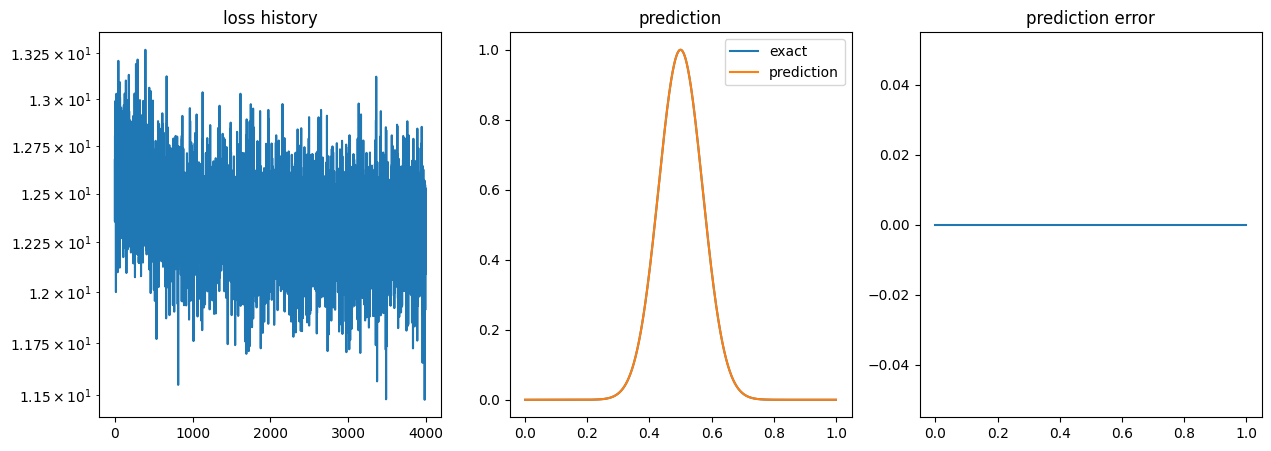

In [ ]:
network.plot(0.0)


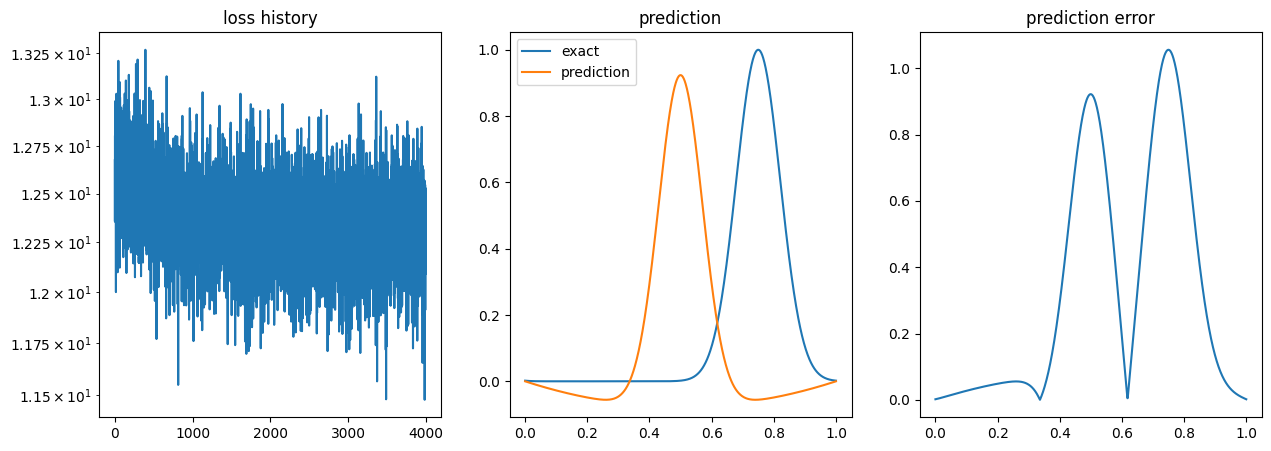

In [ ]:
network.plot(0.25)

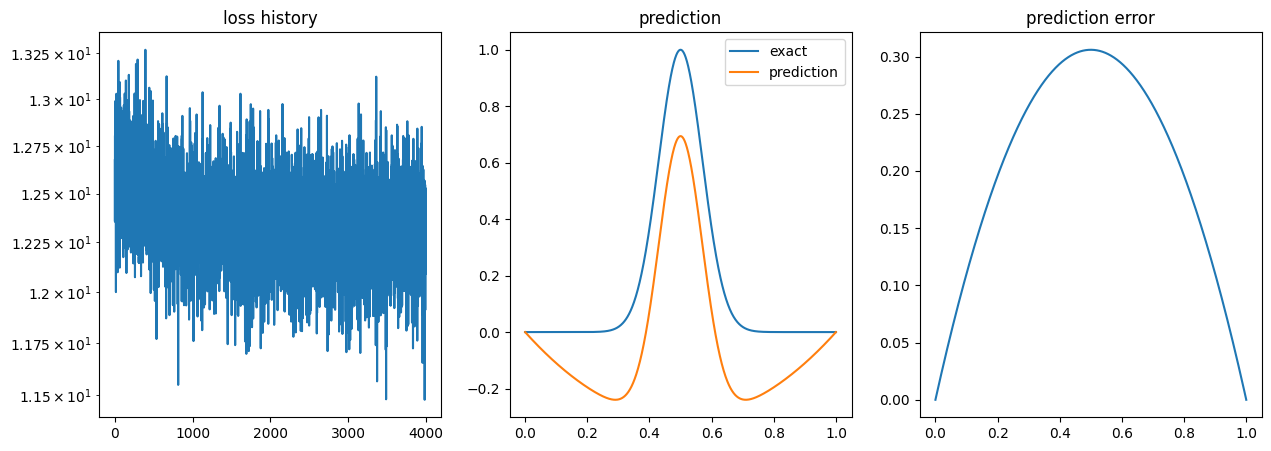

In [ ]:
network.plot(1.)